In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
from sklearn.metrics import roc_auc_score, roc_curve
from scipy import special
from collections import defaultdict
import matplotlib

In [2]:
base_dirs = ['model_scores/deberta_v3_large/open_ai_summarize_from_feedback', 'trial2']

In [3]:
def energy_score(logits, temperature=1.0):
    assert logits.shape[1] == 2
    # implements energy based out of distribution detection
    return (-temperature) * special.logsumexp(logits / temperature, axis=1)
    #return -temperature * (np.log(np.exp(logits / temperature).sum(axis=1)))

In [4]:
def calc_tnr(id_test_ood_scores, ood_test_ood_scores):
    scores = np.concatenate((id_test_ood_scores, ood_test_ood_scores))
    trues = np.array(([0] * len(id_test_ood_scores)) + ([1] * len(ood_test_ood_scores)))
    fpr, tpr, thresholds = roc_curve(trues, scores)
    return 1 - fpr[np.argmax(tpr>=.95)]

def calc_auroc(id_test_ood_scores, ood_test_ood_scores):
    #calculate the AUROC
    scores = np.concatenate((id_test_ood_scores, ood_test_ood_scores))
    trues = np.array(([0] * len(id_test_ood_scores)) + ([1] * len(ood_test_ood_scores)))
    result = roc_auc_score(trues, scores)

    return result

In [5]:
instances = ['prompt', 'response', 'prompt_and_response']
per_trial_auroc, per_trial_fpr = {inst: defaultdict(list) for inst in instances}, {inst: defaultdict(list) for inst in instances}
for base_dir in base_dirs:
    for inst in instances:
        aurocs, fprs = {}, {}
        perturbed_logits = {}
        for f in glob(f'{base_dir}/{inst}/*'):
            df = pd.read_csv(f)
            perturbation = float(os.path.basename(f).split('_')[0][:2]) / 10
            perturbed_logits[perturbation] = df.values
        energy_scores = {}
        for perturbation, logits in perturbed_logits.items():
            energy_scores[perturbation] = energy_score(logits)

        id_test_ood_scores = energy_scores[0.0]
        for perturbation in sorted(energy_scores):
            ood_test_ood_scores = energy_scores[perturbation]
            auroc = calc_auroc(id_test_ood_scores, ood_test_ood_scores)
            tnrATtpr95 = calc_tnr(id_test_ood_scores, ood_test_ood_scores)
            per_trial_auroc[inst][perturbation].append(auroc)
            per_trial_fpr[inst][perturbation].append(1 - tnrATtpr95)

In [6]:
per_trial_fpr

{'prompt': defaultdict(list,
             {0.0: [0.954, 0.954],
              0.1: [0.856, 0.866],
              0.2: [0.798, 0.785],
              0.3: [0.69, 0.698],
              0.4: [0.65, 0.641],
              0.5: [0.584, 0.584],
              0.6: [0.493, 0.5],
              0.7: [0.40900000000000003, 0.4179999999999999],
              0.8: [0.267, 0.29899999999999993],
              0.9: [0.17599999999999993, 0.16800000000000004]}),
 'response': defaultdict(list,
             {0.0: [0.954, 0.954],
              0.1: [0.742, 0.696],
              0.2: [0.43500000000000005, 0.44100000000000006],
              0.3: [0.22499999999999998, 0.22999999999999998],
              0.4: [0.121, 0.121],
              0.5: [0.06400000000000006, 0.06400000000000006],
              0.6: [0.052000000000000046, 0.04800000000000004],
              0.7: [0.04700000000000004, 0.04800000000000004],
              0.8: [0.05400000000000005, 0.051000000000000045],
              0.9: [0.0560000000000000

In [7]:
fpr_avg_inst, fpr_error_inst = {}, {}
auroc_avg_inst, auroc_error_inst = {}, {}
for inst in instances:
    fpr_avg, fpr_error = {}, {}
    auroc_avg, auroc_error = {}, {}
    fprs = per_trial_fpr[inst]
    aurocs = per_trial_auroc[inst]
    for perturbation, val in fprs.items():
        fpr_avg[perturbation] = np.mean(val)
        #fpr_error[perturbation] = 2*np.std(val)
        fpr_error[perturbation] = abs(val[0] - val[1])
    for perturbation, val in aurocs.items():
        auroc_avg[perturbation] = np.mean(val)
        #auroc_error[perturbation] = 2*np.std(val)
        auroc_error[perturbation] = abs(val[0] - val[1])
    fpr_avg_inst[inst] = fpr_avg
    fpr_error_inst[inst] = fpr_error
    auroc_avg_inst[inst] = auroc_avg
    auroc_error_inst[inst] = auroc_error

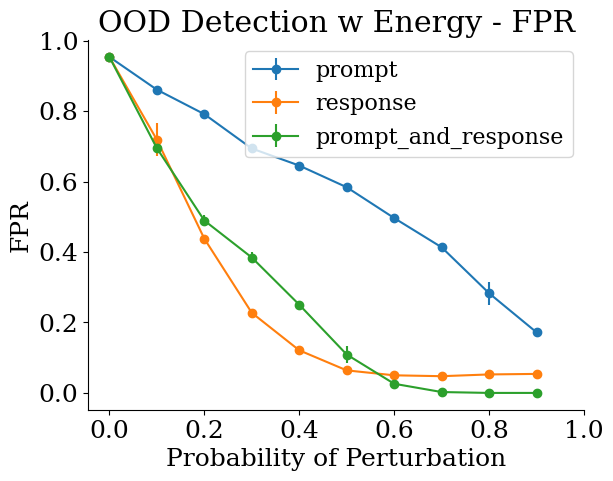

In [8]:
font = {'family': 'serif',
        'weight': 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
ax = plt.subplot()
for inst in instances:
    plt.errorbar(list(fpr_avg_inst[inst].keys()), list(fpr_avg_inst[inst].values()), yerr = list(fpr_error_inst[inst].values()), marker='o', label=inst)
plt.xlabel('Probability of Perturbation')
plt.xticks(np.arange(0, 1.2, step=0.2))
plt.ylabel('FPR')
plt.title('OOD Detection w Energy - FPR')
plt.legend(prop={'size': 16})
ax.spines[['right', 'top']].set_visible(False)

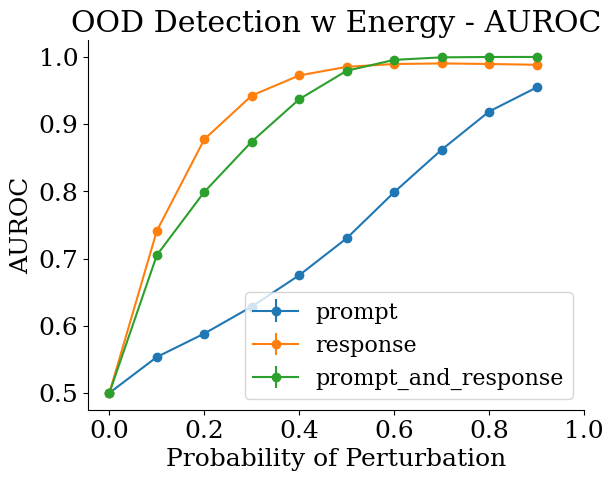

In [9]:
font = {'family': 'serif',
        'weight': 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
ax = plt.subplot()
for inst in instances:
    plt.errorbar(list(auroc_avg_inst[inst].keys()), list(auroc_avg_inst[inst].values()), yerr = list(auroc_error_inst[inst].values()), marker='o', label=inst)
plt.xlabel('Probability of Perturbation')
plt.xticks(np.arange(0, 1.2, step=0.2))
plt.ylabel('AUROC')
plt.title('OOD Detection w Energy - AUROC')
plt.legend(prop={'size': 16})
ax.spines[['right', 'top']].set_visible(False)